#Cyberbullying Detection

##Import Library

In [ ]:
import tensorflow as tf #untuk mengimport pustaka TensorFlow
import pandas as pd #untuk mengimport pustaka pandas ke dalam Python
import numpy as np #untuk mengimport pustaka NumPy ke dalam Python
import nltk #untuk mengimport pustaka NLTK (Natural Language Toolkit) ke dalam Python
from tensorflow.keras.preprocessing.text import Tokenizer #dapat mengimport kelas 'Tokenizer' dari modul 'tensorflow.keras.preprocessing.text'
from tensorflow.keras.preprocessing.sequence import pad_sequences #dapat mengimport fungsi 'pad_sequences' dari modul 'tensorflow.keras.preprocessing.sequence'
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, LSTM, Embedding, Dropout, BatchNormalization, Bidirectional #dapat mengimport berbagai lapisan neural network
from tensorflow.keras.models import Sequential #untuk mengimport kelas Sequential
from tensorflow.keras.regularizers import l2 #untuk mengimport regularisasi L2
from sklearn.model_selection import train_test_split #dapat mengimport fungsi 'train_test_split' dari modul 'sklearn.model_selection'
from nltk.tokenize import word_tokenize #dapat mengimport fungsi word_tokenize
from nltk.stem import WordNetLemmatizer #dapat mengimport kelas WordNetLemmatizer
from nltk.corpus import stopwords #berfungsi mengimpor kumpulan kata berhenti (stopwords)

##Load data

In [ ]:
!mkdir ~/. kaggle

mkdir: cannot create directory ‘/root/.’: File exists


In [ ]:
!cp '/content/kaggle.json' ~/.kaggle

cp: cannot stat '/content/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d andrewmvd/cyberbullying-classification

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification
License(s): Attribution 4.0 International (CC BY 4.0)
 71% 2.00M/2.82M [00:01<00:00, 2.20MB/s]
100% 2.82M/2.82M [00:01<00:00, 2.52MB/s]


In [ ]:
!unzip /content/cyberbullying-classification.zip

Archive:  /content/cyberbullying-classification.zip
  inflating: cyberbullying_tweets.csv  


In [ ]:
df = pd.read_csv("/content/cyberbullying_tweets.csv")
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


##Exploratory Data Analysis

In [ ]:
df.shape #jumlah baris dan kolom

(47692, 2)

In [ ]:
df.isnull().sum() #untuk menghitung jumlah nilai yang hilang (NaN/null) di setiap kolom

tweet_text            0
cyberbullying_type    0
dtype: int64

In [ ]:
df.duplicated().sum() #untuk menghitung jumlah baris yang duplikat

36

In [ ]:
duplicates = df[df.duplicated(keep=False)] #dapat memfilter DataFrame/df, hanya menyertakan baris-baris yang memiliki duplikat, tanpa mengabaikan duplikat mana yang harus dihilangkan
duplicates

,tweet_text,cyberbullying_type
829,Our pancakes are selling like hotcakes Shaz - ...,not_cyberbullying
1712,This is the opportunity to prove ourselves lik...,not_cyberbullying
1758,Our pancakes are selling like hotcakes Shaz - ...,not_cyberbullying
1984,@TVWEEKmag: There is only 1 way to stay in the...,not_cyberbullying
2611,It wouldn't be fair. Kat knows NOTHING of fair...,not_cyberbullying
...,...,...
20604,A Pakistani court has sentenced 86 members of ...,religion
41403,"Still, Davis, who is gay, said he pays a socia...",ethnicity
46915,Racism won't stop as long as u stil select ur ...,ethnicity
46962,"Still, Davis, who is gay, said he pays a socia...",ethnicity


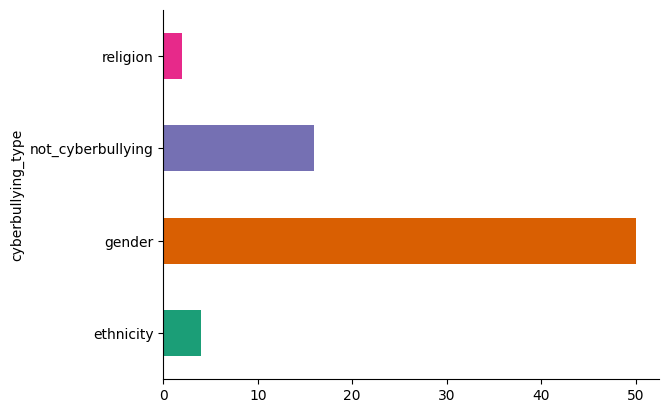

In [ ]:
import seaborn as sns #untuk membuat visualisasi data yang menarik dan informatif dalam analisis data.
import matplotlib.pyplot as plt #untuk membuat berbagai jenis plot dan visualisasi data
duplicates.groupby('cyberbullying_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2')) #melakukan plotting data duplikat yang telah di-grouppkan, tipe cyberbullying, dan dihitung ukuran per grup. Jenis plot yang digunakan adalah dengan warna Dark2
plt.gca().spines[['top', 'right',]].set_visible(False)  #untuk menghilangkan batas di atas dan sebelah kanan

In [ ]:
df.info() #menampilkan informasi tentang DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [ ]:
df['cyberbullying_type'].unique() #digunakan untuk mengambil nilai unik dari kolom 'cyberbullying_type' dalam DataFrame

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [ ]:
df.cyberbullying_type.value_counts() #digunakan untuk menghitung jumlah kemunculan setiap nilai unik dalam kolom 'cyberbullying_type' dalam DataFrame

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

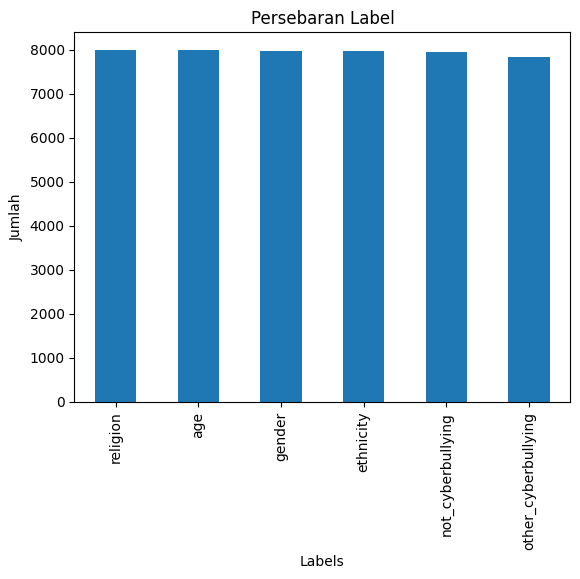

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

label_counts = df['cyberbullying_type'].value_counts()

label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Jumlah')
plt.title('Persebaran Label')
plt.show()

In [ ]:
!pip install wordcloud

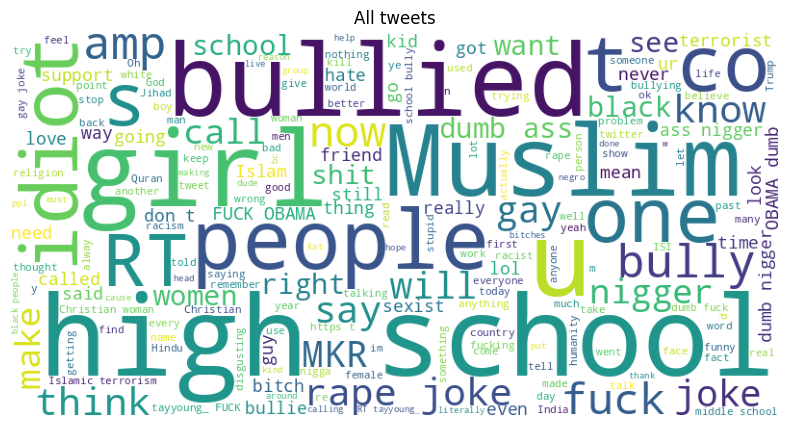

In [ ]:
from wordcloud import WordCloud

# Buat word cloud
text = " ".join(review for review in df['tweet_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Tampilkan word cloud dengan matplotlib

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.title('All tweets')
plt.axis('off')
plt.show()

##Data Pre-processing

In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [ ]:
df.shape

(47656, 2)

In [ ]:
import re
import string

def clean_data (text):
  text = str(text).lower() #membuat teks menjadi lowercase
  text = re.sub ('\[.*?]', '', text) #dapat menghapus teks di dalam tanda ([])
  text = re.sub ('https?://\S+|www\.\S+', '', text) #menghapus semua URL yang diawali dengan ("http", "https", &"www")
  text = re.sub('<.*?>+', '', text) #untuk menghapus semua tag HTML (dilambangkan dengan <...>)
  text = re.sub(r'@[A-Za-z0-9]+', '', text) #dapat menghapus semua username yang dimulai dengan tanda "@" dan diikuti oleh huruf, angka, atau kombinasi keduanya
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #dapat menghapus semua tanda baca dari teks
  text = re.sub('\n', '', text) #untuk menghapus semua karakter newline ('\n')
  text = re.sub('\w*\d\w*', '', text) #dapat menghapus semua kata yang mengandung angka dari string
  return text

In [ ]:
df['tweet_text'] = df['tweet_text'].apply(clean_data)
df.head()

,tweet_text,cyberbullying_type
0,in other words katandandre your food was crapi...,not_cyberbullying
1,why is aussietv so white mkr theblock imaceleb...,not_cyberbullying
2,a classy whore or more red velvet cupcakes,not_cyberbullying
3,gio meh p thanks for the heads up but not too...,not_cyberbullying
4,this is an isis account pretending to be a ku...,not_cyberbullying


In [ ]:
df.duplicated().sum()

687

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words=stopwords.words("english")
more_stopwords=['im','u','amp','co', 't', 's','c', 'p', 'rt','mkr','ur','ass']
stop_words = stop_words + more_stopwords
def stopword(text):
  text=' '.join(word for word in text.split(' ') if word not in stop_words)
  return text

In [ ]:
df['tweet_text'] = df['tweet_text'].apply(stopword)
df.head()

,tweet_text,cyberbullying_type
0,words katandandre food crapilicious,not_cyberbullying
1,aussietv white theblock imacelebrityau today s...,not_cyberbullying
2,classy whore red velvet cupcakes,not_cyberbullying
3,gio meh thanks heads concerned another angry ...,not_cyberbullying
4,isis account pretending kurdish account like...,not_cyberbullying


In [ ]:
df.duplicated().sum()

944

In [ ]:
stemmer=nltk.SnowballStemmer("english")
def stemming(text):
  text=' '.join(stemmer.stem(word) for word in text.split(" "))
  return text

In [ ]:
df['tweet_text'] = df['tweet_text'].apply(stemming)
df.head()

,tweet_text,cyberbullying_type
0,word katandandr food crapilici,not_cyberbullying
1,aussietv white theblock imacelebrityau today s...,not_cyberbullying
2,classi whore red velvet cupcak,not_cyberbullying
3,gio meh thank head concern anoth angri dude t...,not_cyberbullying
4,isi account pretend kurdish account like isl...,not_cyberbullying


In [ ]:
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
def lemmatizing(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df['tweet_text'] = df['tweet_text'].apply(lemmatizing)
df.head()

,tweet_text,cyberbullying_type
0,word katandandr food crapilici,not_cyberbullying
1,aussietv white theblock imacelebrityau today s...,not_cyberbullying
2,classi whore red velvet cupcak,not_cyberbullying
3,gio meh thank head concern anoth angri dude tw...,not_cyberbullying
4,isi account pretend kurdish account like islam...,not_cyberbullying


In [ ]:
df.duplicated().sum()

1314

##Data Analyzing

In [ ]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46342 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          46342 non-null  object
 1   cyberbullying_type  46342 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [ ]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [ ]:
!pip install wordcloud

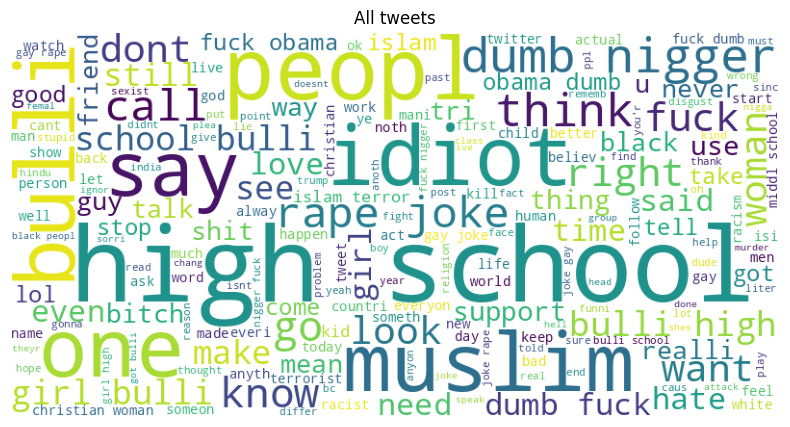

In [ ]:
from wordcloud import WordCloud

# Buat word cloud
text = " ".join(review for review in df['tweet_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Tampilkan word cloud dengan matplotlib

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.title('All tweets')
plt.axis('off')
plt.show()

In [ ]:
nc =df[df['cyberbullying_type']=='not_cyberbullying']

In [ ]:
nc.head()

,tweet_text,cyberbullying_type
0,word katandandr food crapilici,not_cyberbullying
1,aussietv white theblock imacelebrityau today s...,not_cyberbullying
2,classi whore red velvet cupcak,not_cyberbullying
3,gio meh thank head concern anoth angri dude tw...,not_cyberbullying
4,isi account pretend kurdish account like islam...,not_cyberbullying


In [ ]:
nc.shape

(7648, 2)

In [ ]:
nc_length = nc['tweet_text'].apply(len)
avg_nc_length = nc_length.mean()
print ("rata rata panjang teks pada tweet yang tidak mengandung cyber bullying adalah ", avg_nc_length,'karakter')

rata rata panjang teks pada tweet yang tidak mengandung cyber bullying adalah  43.0418410041841 karakter


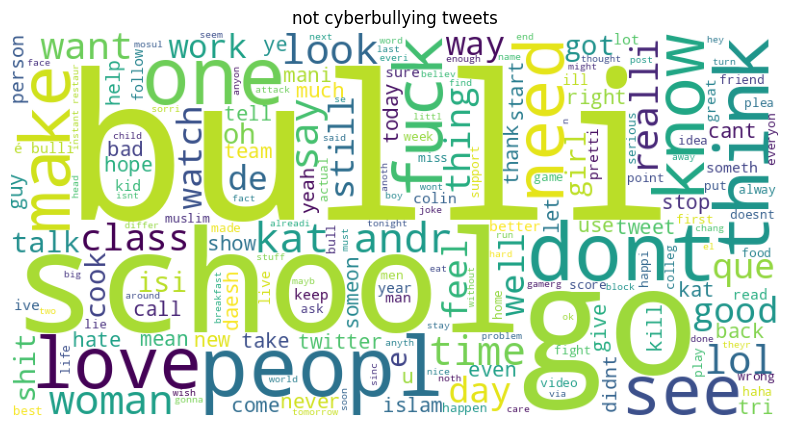

In [ ]:
from wordcloud import WordCloud

# Buat word cloud
text = " ".join(review for review in nc['tweet_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Tampilkan word cloud dengan matplotlib

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.title('not cyberbullying tweets')
plt.axis('off')
plt.show()

In [ ]:
gen = df[df['cyberbullying_type']=='gender']

In [ ]:
gen.head()

,tweet_text,cyberbullying_type
7945,rape realzvasiyana nema joke drunk gay lesbian...,gender
7946,never saw celebr say anyth like obama b maher ...,gender
7947,mean he gay use gender slur make rape joke,gender
7948,aim mecaesm feminazi,gender
7949,rape rape fact read one post guy get rape comm...,gender


In [ ]:
gen.shape

(7685, 2)

In [ ]:
gen_length = gen['tweet_text'].apply(len)
avg_gen_length = gen_length.mean()
print ("rata rata panjang teks pada tweet yang mengandung cyberbullying terkait gender adalah ", avg_gen_length,'karakter')

rata rata panjang teks pada tweet yang mengandung cyberbullying terkait gender adalah  76.47820429407938 karakter


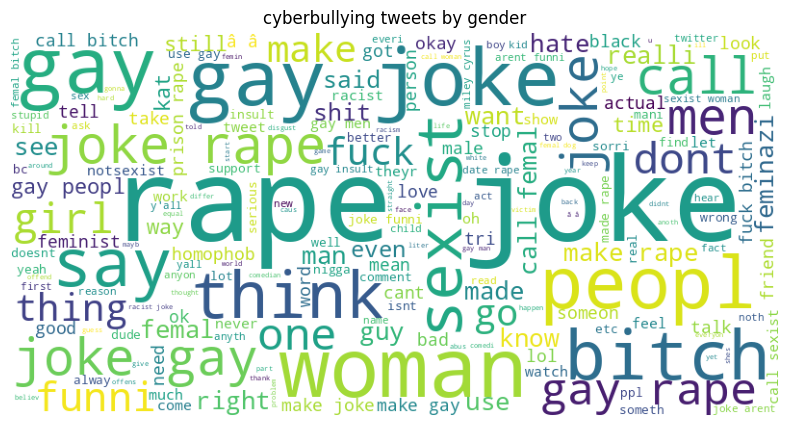

In [ ]:
from wordcloud import WordCloud

# Buat word cloud
text = " ".join(review for review in gen['tweet_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Tampilkan word cloud dengan matplotlib

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.title('cyberbullying tweets by gender')
plt.axis('off')
plt.show()

In [ ]:
rel = df[df['cyberbullying_type']=='religion']
rel.head()

,tweet_text,cyberbullying_type
15918,sudeep invit though right get word your okay p...,religion
15919,islam never resist oppress alway sourc oppress...,religion
15920,boy comment journalist want keep church close ...,religion
15921,hindu get kill muslim terriorist kashmir congr...,religion
15922,white supremicist mani know idiot race antisem...,religion


In [ ]:
rel.shape

(7959, 2)

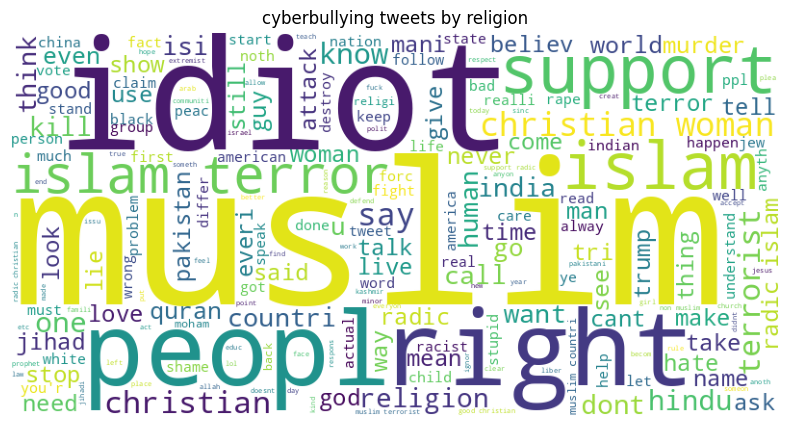

In [ ]:
from wordcloud import WordCloud

# Buat word cloud
text = " ".join(review for review in rel['tweet_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Tampilkan word cloud dengan matplotlib

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.title('cyberbullying tweets by religion')
plt.axis('off')
plt.show()

In [ ]:
rel_length = rel['tweet_text'].apply(len)
avg_rel_length =rel_length.mean()
print ("rata rata panjang teks pada tweet yang mengandung cyberbullying terkait agama adalah ", avg_rel_length,'karakter')

rata rata panjang teks pada tweet yang mengandung cyberbullying terkait agama adalah  112.49453448925745 karakter


In [ ]:
eth = df[df['cyberbullying_type']=='ethnicity']
eth.head()

,tweet_text,cyberbullying_type
39731,hey dumb fuck celeb stop someth peopl public f...,ethnicity
39732,fuck bitch fuck obama dumb nigger,ethnicity
39733,joe racist mani video audio clip racist shit s...,ethnicity
39734,truck look dumb fuck tri make look wors aint c...,ethnicity
39735,nigger food cafe today disgust,ethnicity


In [ ]:
eth.shape

(7764, 2)

In [ ]:
eth_length = eth['tweet_text'].apply(len)
avg_eth_length = eth_length.mean()
print ("rata rata panjang teks pada tweet yang mengandung cyberbullying terkait etnis adalah ", avg_eth_length,'karakter')

rata rata panjang teks pada tweet yang mengandung cyberbullying terkait etnis adalah  81.43160741885626 karakter


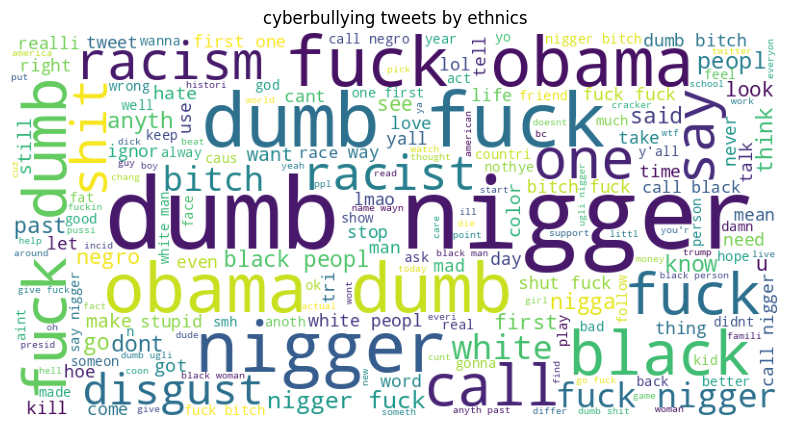

In [ ]:
from wordcloud import WordCloud

# Buat word cloud
text = " ".join(review for review in eth['tweet_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Tampilkan word cloud dengan matplotlib

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.title('cyberbullying tweets by ethnics')
plt.axis('off')
plt.show()

In [ ]:
age = df[df['cyberbullying_type']=='age']
age.head()

,tweet_text,cyberbullying_type
31739,home neighbor pick famili mind son autist feel...,age
31740,bulli school highachiev boy use strategi maint...,age
31741,girl class grade littl autist parent thought i...,age
31742,he probabl white gay kid suburb don't want sho...,age
31743,push ti resort treat thr bulli percent pressur...,age


In [ ]:
age.shape

(7886, 2)

In [ ]:
age_length = age['tweet_text'].apply(len)
avg_age_length = age_length.mean()
print ("rata rata panjang teks pada tweet yang mengandung cyberbullying terkait umur adalah ", avg_age_length,'karakter')

rata rata panjang teks pada tweet yang mengandung cyberbullying terkait umur adalah  99.69426832361147 karakter


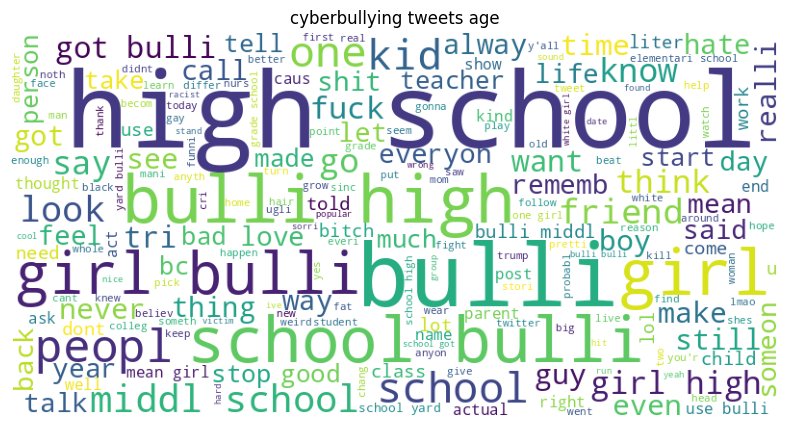

In [ ]:
from wordcloud import WordCloud

# Buat word cloud
text = " ".join(review for review in age['tweet_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Tampilkan word cloud dengan matplotlib

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.title('cyberbullying tweets age')
plt.axis('off')
plt.show()

In [ ]:
oc = df[df['cyberbullying_type']=='other_cyberbullying']
oc.head()

,tweet_text,cyberbullying_type
23916,fyi look like caught botter,other_cyberbullying
23917,need switch organizationbas github dont want p...,other_cyberbullying
23918,rma monopric shoddi power brick get refund pic...,other_cyberbullying
23919,slaw,other_cyberbullying
23920,ive got code interpret analyz weight go take l...,other_cyberbullying


In [ ]:
oc.shape

(7400, 2)

In [ ]:
oc_length = oc['tweet_text'].apply(len)
avg_oc_length = oc_length.mean()
print ("rata rata panjang teks pada tweet yang mengandung cyberbullying yang lain adalah ", avg_oc_length,'karakter')

rata rata panjang teks pada tweet yang mengandung cyberbullying yang lain adalah  42.5 karakter


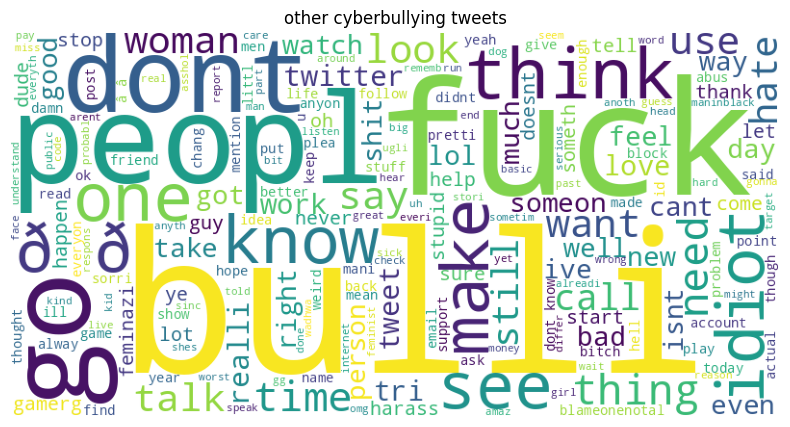

In [ ]:
from wordcloud import WordCloud

# Buat word cloud
text = " ".join(review for review in oc['tweet_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Tampilkan word cloud dengan matplotlib

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.title('other cyberbullying tweets')
plt.axis('off')
plt.show()

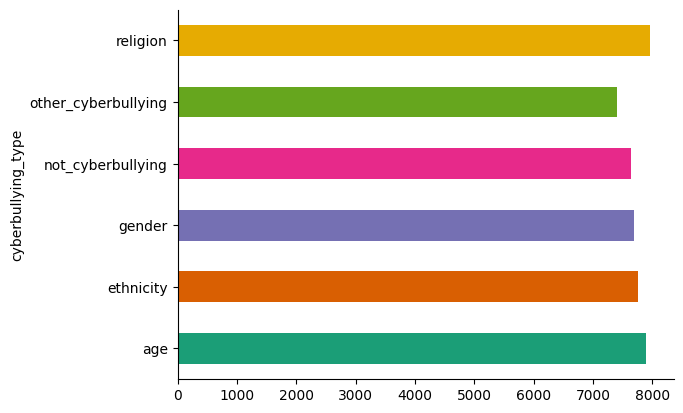

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('cyberbullying_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df['length'] = df['tweet_text'].apply(len)
max_length_text = df.loc[df['length'].idxmax()]
max_length_index = df['length'].idxmax()

print("Teks terpanjang adalah:")
print(max_length_text['tweet_text'])
print("Dengan panjang:", max_length_text['length'])
print("Teks terpanjang berada pada baris ke:", max_length_index)

Teks terpanjang adalah:
feminazi actual word denot… job mean protect peopl even peopl dont agre withlike they bare cook anyth entré mkr rt like communiti foster jerk prevent user adopt communiti code much technic problem it almost time shock your bulli again yeah someon dmed screenshot meh let idea even is for egregi case harass definit need abl respond appropri toxic isnt this so happen realli funni assumpt make work much wrong th lack selfawar right stagger hilari hahahaha this go better final met mother one way another trump evil cabal crimin caught lie impeach wont b moment soon love rock band p i dedic thread rt woman gdc share heartbreak stori gamerg choos respond fr tri still make mistak hard if think presid need congression approv idiot ð rt that though even book reject first draft kill mockingbird befor… aint gonna lie think might tri pomegran cous cous salad sound yum mkr gtfeminazi blad front well arent isi claim muslim theyr belief noth like dont dont fuck ever know anyt

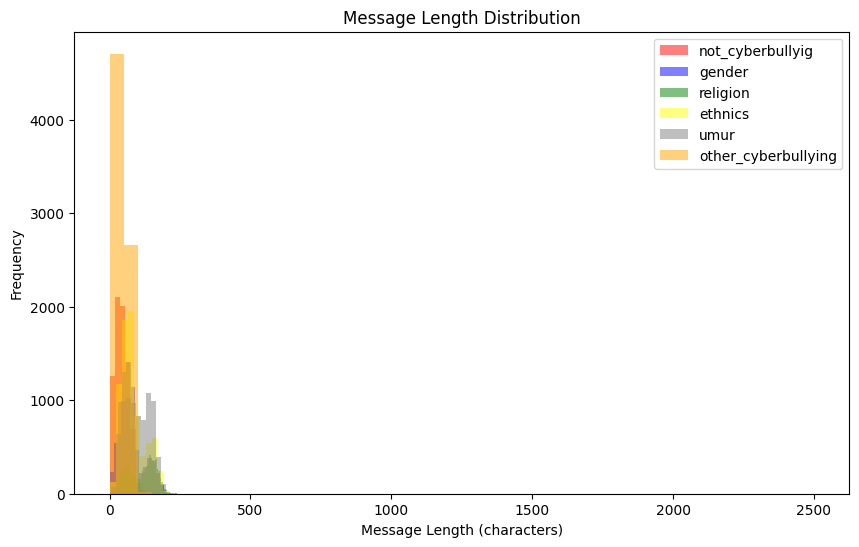

In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(nc_length, bins=50, alpha=0.5, label='not_cyberbullyig', color='red')
plt.hist(gen_length, bins=50, alpha=0.5, label='gender', color='blue')
plt.hist(rel_length, bins=50, alpha=0.5, label='religion', color='green')
plt.hist(eth_length, bins=50, alpha=0.5, label='ethnics', color='yellow')
plt.hist(age_length, bins=50, alpha=0.5, label='umur', color='grey')
plt.hist(oc_length, bins=50, alpha=0.5, label='other_cyberbullying', color='orange')


plt.title('Message Length Distribution')
plt.xlabel('Message Length (characters)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#melakukan penghapusan pada data yang berlabel sebagai other_cyberbullying
df = df[df['cyberbullying_type'] != 'other_cyberbullying']

In [ ]:
df.head()

,tweet_text,cyberbullying_type,length
0,word katandandr food crapilici,not_cyberbullying,30
1,aussietv white theblock imacelebrityau today s...,not_cyberbullying,79
2,classi whore red velvet cupcak,not_cyberbullying,30
3,gio meh thank head concern anoth angri dude tw...,not_cyberbullying,51
4,isi account pretend kurdish account like islam...,not_cyberbullying,50


##Modelling

In [ ]:
df.cyberbullying_type.unique()

array(['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity'],
      dtype=object)

In [ ]:
df = df[['tweet_text','cyberbullying_type']]
df.isna().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [ ]:
class_labels = {
    'not_cyberbullying':0,
    'gender':1,
    'religion':2,
    'age':3,
    'ethnicity':4,
}
df['cyberbullying_type'] = df['cyberbullying_type'].replace(class_labels).astype(int)

In [ ]:
x = df['tweet_text']
y = df['cyberbullying_type']

In [ ]:
y.unique()

array([0, 1, 2, 3, 4])

In [ ]:
from keras.utils import to_categorical
y = to_categorical(y)

print(y)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.3)

In [ ]:
tokenizer = Tokenizer(num_words=5000,oov_token='<oov>')
tokenizer.fit_on_texts(x_train)

txtseq_train = tokenizer.texts_to_sequences(x_train)
txtseq_test = tokenizer.texts_to_sequences(x_test)

txtpadded_train = pad_sequences(txtseq_train)
txtpadded_test = pad_sequences(txtseq_test)

In [ ]:
txtpadded_test

array([[   0,    0,    0, ...,    1,    1,  308],
       [   0,    0,    0, ...,   15,   25,   61],
       [   0,    0,    0, ...,  332,    1,    1],
       ...,
       [   0,    0,    0, ...,    1,    1,    1],
       [   0,    0,    0, ...,  270,  904,   72],
       [   0,    0,    0, ...,  706, 3330,    1]], dtype=int32)

In [ ]:
num_class = 5
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=16))
model.add(LSTM(64, dropout=0.2))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_class, activation='softmax'))

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          80000     
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [ ]:
history = model.fit(txtpadded_train,y_train,validation_data=(txtpadded_test,y_test),epochs=30)

Epoch 1/30
852/852 [==============================] - 43s 40ms/step - loss: 0.5288 - accuracy: 0.8060 - val_loss: 2.4255 - val_accuracy: 0.5999
Epoch 2/30
852/852 [==============================] - 14s 16ms/step - loss: 0.2827 - accuracy: 0.9050 - val_loss: 4.9359 - val_accuracy: 0.3130
Epoch 3/30
852/852 [==============================] - 13s 15ms/step - loss: 0.2312 - accuracy: 0.9239 - val_loss: 1.9046 - val_accuracy: 0.6280
Epoch 4/30
852/852 [==============================] - 12s 14ms/step - loss: 0.2138 - accuracy: 0.9278 - val_loss: 0.4868 - val_accuracy: 0.8256
Epoch 5/30
852/852 [==============================] - 12s 15ms/step - loss: 0.1912 - accuracy: 0.9366 - val_loss: 0.9356 - val_accuracy: 0.7592
Epoch 6/30
852/852 [==============================] - 12s 14ms/step - loss: 0.1786 - accuracy: 0.9398 - val_loss: 0.4569 - val_accuracy: 0.8704
Epoch 7/30
852/852 [==============================] - 11s 12ms/step - loss: 0.1679 - accuracy: 0.9430 - val_loss: 2.3347 - val_accuracy:

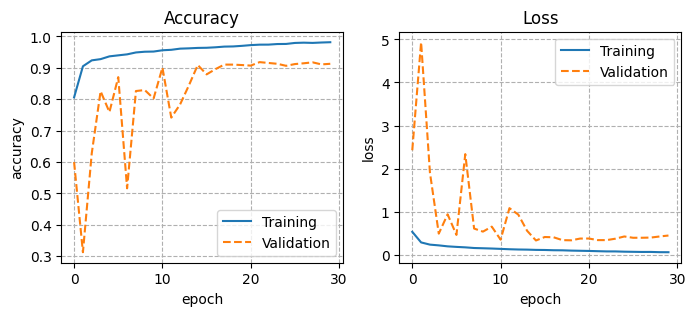

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(accuracy, label='Training')
plt.plot(val_accuracy, label='Validation', linestyle='--')
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation', linestyle='--')
plt.legend()
plt.grid(linestyle='--')

plt.show()

##Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
y_pred_probs = model.predict(txtpadded_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test = np.argmax(y_test, axis=1)

print(classification_report(y_test, y_pred, target_names=class_labels))

366/366 [==============================] - 2s 3ms/step
                   precision    recall  f1-score   support

not_cyberbullying       0.80      0.82      0.81      2327
           gender       0.88      0.87      0.87      2316
         religion       0.95      0.93      0.94      2272
              age       0.96      0.97      0.96      2401
        ethnicity       0.97      0.98      0.98      2367

         accuracy                           0.91     11683
        macro avg       0.91      0.91      0.91     11683
     weighted avg       0.91      0.91      0.91     11683



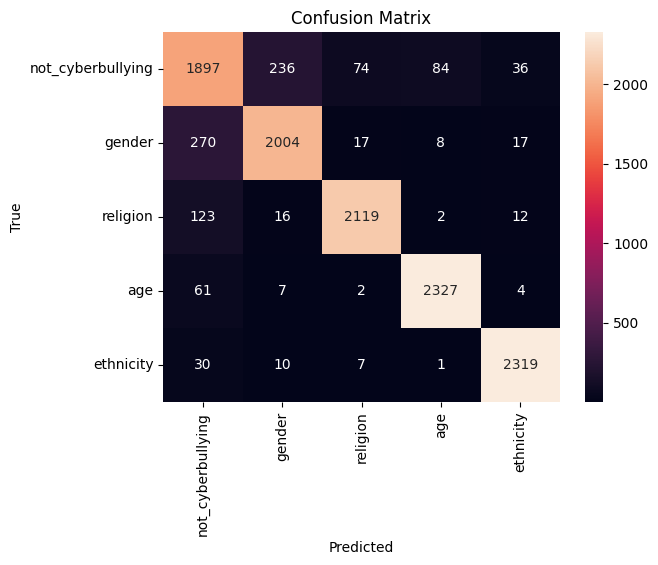

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap=None, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
pred_again = model.predict(np.array([txtpadded_train[0]]))
# txtpadded_train.shape

1/1 [==============================] - 1s 611ms/step


In [ ]:
pred_again

array([[1.4564275e-03, 5.8511301e-07, 2.6464917e-07, 9.9851578e-01,
        2.6968706e-05]], dtype=float32)

##Save Model

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Kesimpulan

*Total tweets :*

*   total tweet bukan cyberbullying tweet : 7945 (16,6%)
*   total tweet gender cyberbullying : 7973 (16,7%)
*   total tweet religion cyberbullying :7998 (16,7%)
*   total tweet age cyberbullying : 7992 (16,7%)
*   total tweet ethnicity cyberbullying : 7961 (16,7%)
*   total cyberbullying tweet yang lain : 7823 (16,4%)

dari penjelasan diatas ditemukan bahwa dataset yang digunakan sudah balance

*Rata - Rata Panjang Karakter Tweets :*

*   panjang tweet bukan cyberbullying tweet :  43.04
*   panjang tweet gender cyberbullying : 76.47
*   panjang tweet religion cyberbullying : 112.49
*   panjang tweet age cyberbullying : 99.69
*   panjang tweet ethnicity cyberbullying : 81.43
*   panjang cyberbullying tweet yang lain : 42.5

dari data diatas menunjukkan bahwa panjang teks mempengaruhi tipe cyberbullying dimana teks yang tidak mengandung unsur cyberbullying biasanya lebih pendek

Tambahan :

Menghapus salah satu kelas yaitu (other_cyberbullying) dengan mempertimbangkan :
1. Kata yang sering muncul kurang lebih sama dengan kelas not_cyberbullying
2. Pajang teks hampir sama dengan kelas not_cyberbullying jika dibanding kelas yang lain
3. Subject other_cyberbullying terkesan kurang jelas tujuannya
4. sudah dilakukan percobaan test pada model dan banyak data yang seharusnya not_cyberbullying namun terdeteksi sebagai other_cyberbullying begitupun sebaliknya terlihat pada confusion matriks


Lanjutan :
pada model yang mana sebelumnya dilakukan penghapusan kelas other_cyberbullying

1. terlihat bahwa model yang ditrain memiliki akurasi dan validasi yang lebih baik (lebih ditidak overvitting)
2. nilai akurasi lebih tinggi, dan pada confusion matriks terlihat bahwa model dapat memprediksi dengan lebih baik dan sesuai

## Testing Data

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

In [ ]:
new_text = 'People like you are ruining our country'
print(new_text)

People like you are ruining our country


In [ ]:
text_prepoc = clean_data(new_text)
encoded_docs_testing = tokenizer.texts_to_sequences(text_prepoc)
max_length = 100
embedded_doc_testing = pad_sequences(encoded_docs_testing, maxlen=max_length)
embedded_doc_testing = np.random.randint(1, 100, size=(1, 100))

testing_data = np.array(embedded_doc_testing)

In [ ]:
predictions = model.predict(testing_data)

1/1 [==============================] - 0s 19ms/step


In [ ]:
predicted_class = np.argmax(predictions, axis=-1)

In [ ]:
probabilities = predictions[0]

In [ ]:
class_names = [
    'Bukan Cyberbullying',
    'Cyberbullying berkaitan dengan gender',
    'Cyberbullying berkaitan dengan agama',
    'Cyberbullying berkaitan dengan umur',
    'Cyberbullying berkaitan dengan etnisitas'
]
predicted_class_index = predicted_class[0]
predicted_class_name = class_names[predicted_class_index]

for pred_class in predicted_class:
    predicted_class_name = class_names[pred_class]
    print(f"Teks ini diprediksi sebagai: {predicted_class_name}")

print ('dengan probability :')
for class_name, prob in zip(class_names, probabilities):
    print(f"{class_name}: {prob:.4f}")

Teks ini diprediksi sebagai: Cyberbullying berkaitan dengan etnisitas
dengan probability :
Bukan Cyberbullying: 0.0000
Cyberbullying berkaitan dengan gender: 0.0000
Cyberbullying berkaitan dengan agama: 0.0000
Cyberbullying berkaitan dengan umur: 0.0000
Cyberbullying berkaitan dengan etnisitas: 1.0000
